In [1]:
import pandas as pd
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fsolve

C:\Users\guiar\AppData\Local\Temp\ipykernel_24284\1813189295.py:239: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(par_values_simulation))
CasADi - 2025-07-01 15:57:20 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:692]


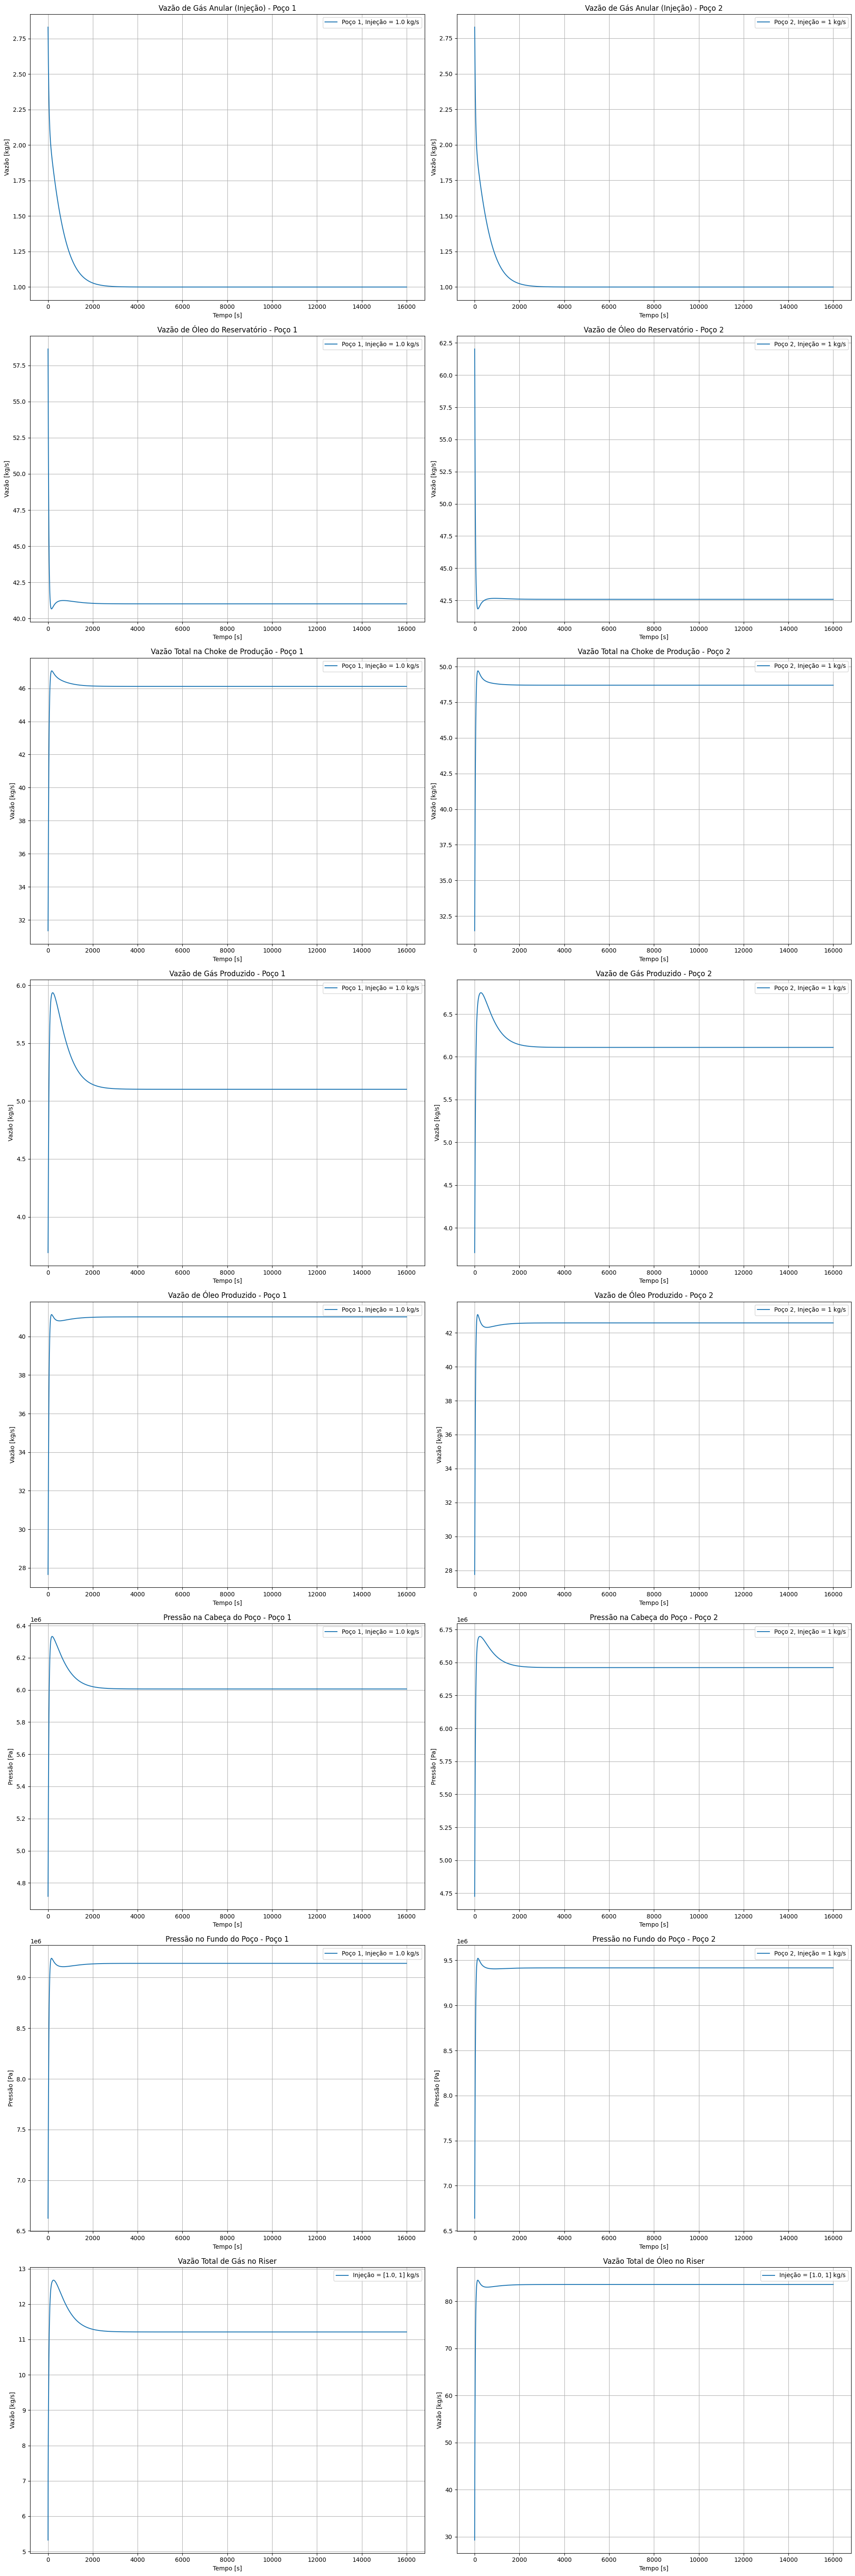

In [2]:


# Constantes Fundamentais
g = 9.81  # Aceleração da gravidade [m/s²]
R = 8.314 # Constante dos gases [J/mol.K]

# Parâmetros Gerais do Sistema 
M = 0.028 # Massa molar do gás [kg/mol]
ro_o = 800 # Densidade do óleo no reservatório [kg/m³] 
Ps = 2e6  # Pressão do separador [Pa]
vo = 1 / ro_o # Volume específico do óleo [m³/kg]
GOR_geral = 0.1 # Razão Gás-Óleo [kg/kg] 
# Parâmetros do Riser
Dr = 0.121 # Diâmetro do riser [m]
Hr_riser_comum = 500 # Altura vertical do riser
Tr_riser_comum = 301 # Temperatura do riser [K] 
Crh = 10e-3 # Coeficiente da válvula da cabeça do riser [m²]
Ar_riser_comum = (ca.pi * (Dr ** 2)) / 4 # Área da seção transversal do riser [m²]
Ta = 28 + 273.15
# --- Parâmetros do Poço 1 ---
# Geometria e Temperaturas
Lw1 = 1500 # Comprimento do tubo [m]
Dw1 = 0.121 # Diâmetro do poço [m]
Hw1 = 1000 # Altura de coluna hidrostática no poço [m]
Hbh1 = 500
Lbh1 = 500 # Comprimento do poço abaixo do ponto de injeção [m]
Dbh1 = 0.121 # Diâmetro da seção abaixo do ponto injeção [m]
Tw1 = 305 # Temperatura no tubo [K]

La1 = 1500 # Comprimento da região anular [m]
Dr= 0.121
Da1 = 0.189 # Diâmetro do anular [m]
Ha1 = 1000 # Altura da região anular [m]
Ta1 = 301 # Temperatura da região anular [K]

# Coeficientes e Propriedades
PI1 = 0.7e-5 # Índice de Produtividade [kg/(s·Pa)]
Cpc1 = 2e-3 # Coeficiente da choke de produção [m²]
Civ1 = 0.1e-3 # Coeficiente da válvula de injeção [m²]
Pr1 = 1.50e7 # Pressão no reservatório [Pa]
Lr_poco1 = 500 # Distância do reservatório até o ponto de injeção 
GOR1 = 0.1 # Razão Gás-Óleo [kg/kg] 

# Áreas e Volumes Calculados para Poço 1
Aw1 = (ca.pi * (Dw1 ** 2)) / 4 # Área da seção transversal do poço [m²]
Aa1 = (ca.pi * (Da1 ** 2)) / 4 - (ca.pi * (Dw1 ** 2)) / 4 # Área da seção transversal do anel [m²]
Abh1 = (ca.pi * (Dbh1 ** 2)) / 4 # Área da seção transversal abaixo do ponto de injeção [m²]
Ar1 = (ca.pi * (Dr ** 2)) / 4 
Va1 = La1 * Aa1 # Volume da região anular [m³]

# --- Parâmetros do Poço 2 
# Geometria e Temperaturas
Lw2 = 1500
Lr2=500
Dw2 = 0.121
Hw2 = 1000
Lbh2 = 500
Hbh2 = 500
Dbh2 = 0.121
Tw2 = 305
Lr1=500
La2 = 1500
Da2 = 0.189
Dr= 0.121
Ha2 = 1000
Ta2 = 301

# Coeficientes e Propriedades
PI2 = 0.7e-5 # Pode ser diferente, exemplo: 0.23e-5
Cpc2 = 2e-3
Civ2 = 0.1e-3
Pr2 = 1.55e7 # Diferente do poço 1
Lr_poco2 = 500
GOR2 = 0.12 # Diferente do poço 1

# Áreas e Volumes Calculados para Poço 2
Aw2 = (ca.pi * (Dw2 ** 2)) / 4
Aa2 = (ca.pi * (Da2 ** 2)) / 4 - (ca.pi * (Dw2 ** 2)) / 4
Abh2 = (ca.pi * (Dbh2 ** 2)) / 4
Ar2 = (ca.pi * (Dr ** 2)) / 4 
Va2 = La2 * Aa2


Lr_comum = 500 # Length do riser comum
Ar_comum = 0.0114 # Area do riser comum
Crh = 10E-3
Tr_comum = 30 + 273.15 # Temperatura média no riser em K



dp_fric_t1 = 0
dp_fric_bh1 = 0
dp_fric_t2 = 0
dp_fric_bh2 = 0
dp_fric_r_comum = 0


# --- Função de Equações Diferenciais (fun) ---
def fun(t, x, par):
    
    # x[0]: m_ga1 (massa de gás no anular do poço 1)
    # x[1]: m_ga2 (massa de gás no anular do poço 2)
    # x[2]: m_gt1 (massa de gás no tubo do poço 1)
    # x[3]: m_gt2 (massa de gás no tubo do poço 2)
    # x[4]: m_ot1 (massa de óleo no tubo do poço 1)
    # x[5]: m_ot2 (massa de óleo no tubo do poço 2)
    # x[6]: m_gr (massa de gás no riser comum)
    # x[7]: m_or (massa de óleo no riser comum)

    # Parâmetros: (Vazões de injeção de gás para cada poço)
    wgl1, wgl2 = par[0], par[1]

    # --- Cálculos para o Poço 1 (Espelhados do seu código original para x[0], x[2], x[4]) ---
    # Adaptação das suas fórmulas com as variáveis de Poço 1
    Pai1 = ((R * Ta1 / (Va1 * M)) + ((g * Ha1) / (La1 * Aa1))) * x[0]
    ro_w1 = (x[2] + x[4] - (ro_o * Lr1 * Ar1)) / (Lw1 * Aw1) # Lr1*Ar1 é a forma do seu código
    Pwh1 = (R * Tw1 / M) * (x[2] / (Lw1 * Aw1 + Lr1 * Ar1 - (vo * x[4]))) # Replicando 'vo * x3' com 'ro_o * x[4]' e 'Lr * Ar' com 'Lr1 * Ar1'

    

    Pwi1 = Pwh1 + g / (Lw1 * Aw1) * (x[4] + x[2] - ro_o * Lr1 * Ar1) * Hw1 + dp_fric_t1 
    Pbh1 = Pwi1 + (ro_w1 * g * Hbh1) + dp_fric_bh1
    ro_a1 = (M * Pai1) / (R * Ta)
    wiv1 = Civ1 * ca.sqrt(ca.fmax(0, ro_a1 * (Pai1 - Pwi1)))
    wro1 = PI1 * (Pr1 - Pbh1)
    wrg1 = GOR1 * wro1

   
    Pai2 = ((R * Ta2 / (Va2 * M)) + ((g * Ha2) / (La2 * Aa2))) * x[1]
    ro_w2 = (x[3] + x[5] - (ro_o * Lr2 * Ar2)) / (Lw2 * Aw2)
    Pwh2 = (R * Tw2 / M) * (x[3] / (Lw2 * Aw2 + Lr2 * Ar2 - (vo * x[5])))


    ro_a2 = (M * Pai2) / (R * Ta)
    Pwi2 = Pwh2 + g / (Lw2 * Aw2) * (x[5] + x[3] - ro_o * Lr2 * Ar2) * Hw2 + dp_fric_t2
    Pbh2 = Pwi2 + (ro_w2 * g * Hbh2) + dp_fric_bh2

    wiv2 = Civ2 * ca.sqrt(ca.fmax(0, ro_a2 * (Pai2 - Pwi2)))
    wro2 = PI2 * (Pr2 - Pbh2)
    wrg2 = GOR2 * wro2


    ro_r = (x[6] + x[7]) / (Lr_comum * Ar_comum)
    Prh = (Tr_comum * R / M) * (x[6] / (Lbh1 * Abh1)) 
    Pm = Prh + (ro_r * g * Hbh1) + dp_fric_r_comum 

    # Vazões de produção na cabeça do poço (para cada poço, dependendo do Pm comum)
    y3_1 = ca.fmax(0, (Pwh1 - Pm))
    wpc1 = Cpc1 * ca.sqrt(ro_w1 * y3_1) # Sua fórmula original de wpc
    wpg1_prod = (x[2] / (x[2] + x[4])) * wpc1
    wpo1_prod = (x[4] / (x[2] + x[4])) * wpc1

    y3_2 = ca.fmax(0, (Pwh2 - Pm))
    wpc2 = Cpc2 * ca.sqrt(ro_w2 * y3_2)
    wpg2_prod = (x[3] / (x[3] + x[5])) * wpc2
    wpo2_prod = (x[5] / (x[3] + x[5])) * wpc2

    # Vazões totais no riser
    y4_rh = ca.fmax(0, (Prh - Ps))
    wrh = Crh * ca.sqrt(ro_r * y4_rh)
    wtg = (x[6] / (x[6] + x[7])) * wrh
    wto = (x[7] / (x[6] + x[7])) * wrh

    # --- Derivadas dos Estados ---
    dx0 = wgl1 - wiv1  # m_ga1
    dx1 = wgl2 - wiv2  # m_ga2
    dx2 = wiv1 + wrg1 - wpg1_prod  # m_gt1 (usando wpg1_prod)
    dx3 = wiv2 + wrg2 - wpg2_prod  # m_gt2 (usando wpg2_prod)
    dx4 = wro1 - wpo1_prod  # m_ot1 (usando wpo1_prod)
    dx5 = wro2 - wpo2_prod  # m_ot2 (usando wpo2_prod)
    dx6 = wpg1_prod + wpg2_prod - wtg  # m_gr (somando contribuições)
    dx7 = wpo1_prod + wpo2_prod - wto  # m_or (somando contribuições)

    return ca.vertcat(dx0, dx1, dx2, dx3, dx4, dx5, dx6, dx7)



def modelo(x, par):
    wgl1, wgl2 = par[0], par[1]

    # --- Cálculos para o Poço 1 ---
    
    Pai1 = ((R * Ta1 / (Va1 * M)) + ((g * Ha1) / (La1 * Aa1))) * x[0]
    ro_w1 = (x[2] + x[4] - (ro_o * Lr1 * Ar1)) / (Lw1 * Aw1)
    Pwh1 = (R * Tw1 / M) * (x[2] / (Lw1 * Aw1 + Lr1 * Ar1 - (vo * x[4])))
    Pwi1 = Pwh1 + g / (Lw1 * Aw1) * (x[4] + x[2] - ro_o * Lr1 * Ar1) * Hw1 + dp_fric_t1
    Pbh1 = Pwi1 + (ro_w1 * g * Hbh1) + dp_fric_bh1
    ro_a1 = (M * Pai1) / (R * Ta)
    wiv1 = Civ1 * ca.sqrt(ca.fmax(0, ro_a1 * (Pai1 - Pwi1)))
    wro1 = PI1 * (Pr1 - Pbh1)
    wrg1 = GOR1 * wro1
    
    # --- Cálculos para o Poço 2 ---
    Pai2 = ((R * Ta2 / (Va2 * M)) + ((g * Ha2) / (La2 * Aa2))) * x[1]
    ro_a2 = (M * Pai2) / (R * Ta)
    ro_w2 = (x[3] + x[5] - (ro_o * Lr2 * Ar2)) / (Lw2 * Aw2)
    Pwh2 = (R * Tw2 / M) * (x[3] / (Lw2 * Aw2 + Lr2 * Ar2 - (vo * x[5])))
    Pwi2 = Pwh2 + g / (Lw2 * Aw2) * (x[5] + x[3] - ro_o * Lr2 * Ar2) * Hw2 + dp_fric_t2
    Pbh2 = Pwi2 + (ro_w2 * g * Hbh2) + dp_fric_bh2
    wiv2 = Civ2 * ca.sqrt(ca.fmax(0, ro_a2 * (Pai2 - Pwi2)))
    wro2 = PI2 * (Pr2 - Pbh2)
    wrg2 = GOR2 * wro2

    # --- Cálculos para o Riser Comum ---
    ro_r = (x[6] + x[7]) / (Lr_comum * Ar_comum)
    Prh = (Tr_comum * R / M) * (x[6] / (Lbh1 * Abh1))
    Pm = Prh + (ro_r * g * Hbh1) + dp_fric_r_comum

    y3_1 = ca.fmax(0, (Pwh1 - Pm))
    wpc1 = Cpc1 * ca.sqrt(ro_w1 * y3_1)
    wpg1_prod = (x[2] / (x[2] + x[4])) * wpc1
    wpo1_prod = (x[4] / (x[2] + x[4])) * wpc1

    y3_2 = ca.fmax(0, (Pwh2 - Pm))
    wpc2 = Cpc2 * ca.sqrt(ro_w2 * y3_2)
    wpg2_prod = (x[3] / (x[3] + x[5])) * wpc2
    wpo2_prod = (x[5] / (x[3] + x[5])) * wpc2

    y4_rh = ca.fmax(0, (Prh - Ps))
    wrh = Crh * ca.sqrt(ro_r * y4_rh)
    wtg = (x[6] / (x[6] + x[7])) * wrh
    wto = (x[7] / (x[6] + x[7])) * wrh

    return [
        wiv1, wro1, wpc1, wpg1_prod, wpo1_prod, Pai1, Pwh1, Pwi1, Pbh1, wrg1, # Poço 1
        wiv2, wro2, wpc2, wpg2_prod, wpo2_prod, Pai2, Pwh2, Pwi2, Pbh2, wrg2, # Poço 2
        wtg, wto, Prh, Pm, ro_r, wrh # Riser e variáveis comuns
    ]


par_values_simulation = [ [1.0, 1]] # [wgl1, wgl2]

t0 = 1
tf = 16000
dt = 1


# [m_ga1, m_ga2, m_gt1, m_gt2, m_ot1, m_ot2, m_gr, m_or]
y0 = [3000 ,3000,800,800, 6000, 6000, 130, 700] # Duplicando valores iniciais para 2 poços

cmap = plt.cm.get_cmap("tab10", len(par_values_simulation))

# Definição das equações diferenciais para CasADi
x_sym = ca.SX.sym('x', 8) # 8 estados
p_sym = ca.SX.sym('p', 2) # 2 parâmetros (vazões de injeção de gás)

dx_sym = fun(0, x_sym, p_sym)
f_ode = ca.Function('f_ode', [x_sym, p_sym], [dx_sym])

dae = {'x': x_sym, 'p': p_sym, 'ode': dx_sym}
opts = {'tf': dt}
integrator = ca.integrator('integrator', 'rk', dae, opts)

plt.figure(figsize=(20, 60)) # Ajuste o tamanho da figura para acomodar mais plots

t = np.arange(t0, tf, dt)

for i, par_pair in enumerate(par_values_simulation):
    x_current = np.array(y0)
    saidas = []

    for ti in t:
        res = integrator(x0=x_current, p=par_pair)
        x_next = res['xf']
        saidas.append(modelo(x_next.full().flatten(), par_pair))
        x_current = x_next

    saidas = np.array(saidas).T


    # Vazões de Gás Anular (Injeção de Gás Lift)
    plt.subplot(len(par_values_simulation) * 8, 2, 1 + i*16)
    plt.plot(t, saidas[0, :], color=cmap(i), label=f'Poço 1, Injeção = {par_pair[0]} kg/s')
    plt.title("Vazão de Gás Anular (Injeção) - Poço 1")
    plt.xlabel("Tempo [s]")
    plt.ylabel("Vazão [kg/s]")
    plt.grid()
    plt.legend()

    plt.subplot(len(par_values_simulation) * 8, 2, 2 + i*16)
    plt.plot(t, saidas[10, :], color=cmap(i), label=f'Poço 2, Injeção = {par_pair[1]} kg/s')
    plt.title("Vazão de Gás Anular (Injeção) - Poço 2")
    plt.xlabel("Tempo [s]")
    plt.ylabel("Vazão [kg/s]")
    plt.grid()
    plt.legend()

    # Vazão de Óleo do Reservatório para o Tubo
    plt.subplot(len(par_values_simulation) * 8, 2, 3 + i*16)
    plt.plot(t, saidas[1, :], color=cmap(i), label=f'Poço 1, Injeção = {par_pair[0]} kg/s')
    plt.title("Vazão de Óleo do Reservatório - Poço 1")
    plt.xlabel("Tempo [s]")
    plt.ylabel("Vazão [kg/s]")
    plt.grid()
    plt.legend()

    plt.subplot(len(par_values_simulation) * 8, 2, 4 + i*16)
    plt.plot(t, saidas[11, :], color=cmap(i), label=f'Poço 2, Injeção = {par_pair[1]} kg/s')
    plt.title("Vazão de Óleo do Reservatório - Poço 2")
    plt.xlabel("Tempo [s]")
    plt.ylabel("Vazão [kg/s]")
    plt.grid()
    plt.legend()

    # Vazão Total na Choke de Produção
    plt.subplot(len(par_values_simulation) * 8, 2, 5 + i*16)
    plt.plot(t, saidas[2, :], color=cmap(i), label=f'Poço 1, Injeção = {par_pair[0]} kg/s')
    plt.title("Vazão Total na Choke de Produção - Poço 1")
    plt.xlabel("Tempo [s]")
    plt.ylabel("Vazão [kg/s]")
    plt.grid()
    plt.legend()

    plt.subplot(len(par_values_simulation) * 8, 2, 6 + i*16)
    plt.plot(t, saidas[12, :], color=cmap(i), label=f'Poço 2, Injeção = {par_pair[1]} kg/s')
    plt.title("Vazão Total na Choke de Produção - Poço 2")
    plt.xlabel("Tempo [s]")
    plt.ylabel("Vazão [kg/s]")
    plt.grid()
    plt.legend()

    # Vazão de Gás Produzido na Cabeça do Poço
    plt.subplot(len(par_values_simulation) * 8, 2, 7 + i*16)
    plt.plot(t, saidas[3, :], color=cmap(i), label=f'Poço 1, Injeção = {par_pair[0]} kg/s')
    plt.title("Vazão de Gás Produzido - Poço 1")
    plt.xlabel("Tempo [s]")
    plt.ylabel("Vazão [kg/s]")
    plt.grid()
    plt.legend()

    plt.subplot(len(par_values_simulation) * 8, 2, 8 + i*16)
    plt.plot(t, saidas[13, :], color=cmap(i), label=f'Poço 2, Injeção = {par_pair[1]} kg/s')
    plt.title("Vazão de Gás Produzido - Poço 2")
    plt.xlabel("Tempo [s]")
    plt.ylabel("Vazão [kg/s]")
    plt.grid()
    plt.legend()

    # Vazão de Óleo Produzido na Cabeça do Poço
    plt.subplot(len(par_values_simulation) * 8, 2, 9 + i*16)
    plt.plot(t, saidas[4, :], color=cmap(i), label=f'Poço 1, Injeção = {par_pair[0]} kg/s')
    plt.title("Vazão de Óleo Produzido - Poço 1")
    plt.xlabel("Tempo [s]")
    plt.ylabel("Vazão [kg/s]")
    plt.grid()
    plt.legend()

    plt.subplot(len(par_values_simulation) * 8, 2, 10 + i*16)
    plt.plot(t, saidas[14, :], color=cmap(i), label=f'Poço 2, Injeção = {par_pair[1]} kg/s')
    plt.title("Vazão de Óleo Produzido - Poço 2")
    plt.xlabel("Tempo [s]")
    plt.ylabel("Vazão [kg/s]")
    plt.grid()
    plt.legend()

    # Pressão na Cabeça do Poço
    plt.subplot(len(par_values_simulation) * 8, 2, 11 + i*16)
    plt.plot(t, saidas[6, :], color=cmap(i), label=f'Poço 1, Injeção = {par_pair[0]} kg/s')
    plt.title("Pressão na Cabeça do Poço - Poço 1")
    plt.xlabel("Tempo [s]")
    plt.ylabel("Pressão [Pa]")
    plt.grid()
    plt.legend()

    plt.subplot(len(par_values_simulation) * 8, 2, 12 + i*16)
    plt.plot(t, saidas[16, :], color=cmap(i), label=f'Poço 2, Injeção = {par_pair[1]} kg/s')
    plt.title("Pressão na Cabeça do Poço - Poço 2")
    plt.xlabel("Tempo [s]")
    plt.ylabel("Pressão [Pa]")
    plt.grid()
    plt.legend()

    # Pressão no Fundo do Poço
    plt.subplot(len(par_values_simulation) * 8, 2, 13 + i*16)
    plt.plot(t, saidas[8, :], color=cmap(i), label=f'Poço 1, Injeção = {par_pair[0]} kg/s')
    plt.title("Pressão no Fundo do Poço - Poço 1")
    plt.xlabel("Tempo [s]")
    plt.ylabel("Pressão [Pa]")
    plt.grid()
    plt.legend()

    plt.subplot(len(par_values_simulation) * 8, 2, 14 + i*16)
    plt.plot(t, saidas[18, :], color=cmap(i), label=f'Poço 2, Injeção = {par_pair[1]} kg/s')
    plt.title("Pressão no Fundo do Poço - Poço 2")
    plt.xlabel("Tempo [s]")
    plt.ylabel("Pressão [Pa]")
    plt.grid()
    plt.legend()
    
    # Vazão Total de Gás no Riser
    plt.subplot(len(par_values_simulation) * 8, 2, 15 + i*16)
    plt.plot(t, saidas[20, :], color=cmap(i), label=f'Injeção = {par_pair} kg/s')
    plt.title("Vazão Total de Gás no Riser")
    plt.xlabel("Tempo [s]")
    plt.ylabel("Vazão [kg/s]")
    plt.grid()
    plt.legend()

    # Vazão Total de Óleo no Riser
    plt.subplot(len(par_values_simulation) * 8, 2, 16 + i*16)
    plt.plot(t, saidas[21, :], color=cmap(i), label=f'Injeção = {par_pair} kg/s')
    plt.title("Vazão Total de Óleo no Riser")
    plt.xlabel("Tempo [s]")
    plt.ylabel("Vazão [kg/s]")
    plt.grid()
    plt.legend()


plt.tight_layout()
plt.show()